## Data Bootcamp Final Project: The Effects of State Medicaid Expansion on State Drug Spending ##

**Author:** Davina Francki

**Email:** df1559@stern.nyu.edu

This project will study how a state's decision whether or not to expand Medicaid in 2014 has affected [prescription drug utilization](https://www.medicaid.gov/medicaid/prescription-drugs/state-drug-utilization-data/index.html). State drug utilization spending represents the amount of prescription drugs reimbursed by Medicaid. [Medicaid expansion](https://www.americanprogress.org/issues/healthcare/news/2013/04/02/58922/10-frequently-asked-questions-about-medicaid-expansion/) involves extending coverage to individuals with incomes below 138% of the federal poverty line. Therefore, it would seem that extending coverage would increase the number of medications a state has to reimburse. So this project aims to answer the question: Do states that have expanded Medicaid now pay more in drug reimbursements than their non-expansion counterparts?

In 2012, the [Supreme Court ruled](https://www.nytimes.com/2012/06/29/us/supreme-court-lets-health-law-largely-stand.html) that states could not be coerced into expanding Medicaid via the Affodable Care Act. Instead it was up to each state to decide whether or not to expand the program. [Here](https://www.kff.org/health-reform/state-indicator/state-activity-around-expanding-medicaid-under-the-affordable-care-act/?currentTimeframe=0&sortModel=%7B%22colId%22:%22Location%22,%22sort%22:%22asc%22%7D) is a current list of states' expansion status. 

To gain access to this data, the [Socrata Open Data API](https://dev.socrata.com) must be used. It provides access to a wide variety of datasets available on the [Medicaid.gov](https://www.medicaid.gov/index.html) site. This includes access to [state drug utilization data](https://www.medicaid.gov/medicaid/prescription-drugs/state-drug-utilization-data/index.html) at both the national and state levels as well as [Medicaid state expansion status](https://data.medicaid.gov/Enrollment/State-Medicaid-and-CHIP-Applications-Eligibility-D/n5ce-jxme).

## Data Report and Steps:

This project is split into three sections:

1. First, I determine which states have decided to expand Medicare. This involves reading in the [State Medicaid Enrollment Status](https://data.medicaid.gov/Enrollment/State-Medicaid-and-CHIP-Applications-Eligibility-D/n5ce-jxme) data set from [Medicaid.gov](https://www.medicaid.gov/index.html). This data set contains a column that gives a state's expansion status. From this column I create a map that shows which states have expanded and which states have not. This map is based off of a [shape file](https://github.com/Davina-Francki/Data_Bootcamp_Final_Project/blob/master/USA_Map/cb_2017_us_state_20m.shx) located in the [USA_Map folder](https://github.com/Davina-Francki/Data_Bootcamp_Final_Project/tree/master/USA_Map) in my repository. I found this file on [census.gov](https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html).

2. Next, I look at the trends of drug utilization and reimbursement over time. Medicaid expansion went into effect on January 1, 2014, so I want to look at the years 2014-2017 and compare them with the four years prior to implementation (2010-2013). This involves reading in and manipulating [Yearly State Drug Utilization Data](https://www.medicaid.gov/medicaid/prescription-drugs/state-drug-utilization-data/index.html). The data again comes from [Medicaid.gov](https://www.medicaid.gov/index.html), but this time I use the [Socrata Open Data API](https://dev.socrata.com). By creating an account I receive a token which I can use to pull the large yearly data sets. These data sets were much larger than I initially anticipated. Each year has around four million rows, and even after selectively reading in only rows of interest, they still had over two million rows of data each. Therefore, I decided to clean this data in a separate notebook entitled [SDU_Data_Cleaning](https://github.com/Davina-Francki/Data_Bootcamp_Final_Project/blob/master/SDU_Data/SDU_Data_Cleaning.ipynb) which is available in the [SDU_Data folder](https://github.com/Davina-Francki/Data_Bootcamp_Final_Project/tree/master/SDU_Data) found in the repository. After reading in about two or three years' worth of data my computer would either read in the next file extremely slowly or freeze. Therefore, I handle each year separately in the notebook. Each year split state spending by drug, so I read in the data and cleaned it so that I would have a yearly total for each state. I then combined these yearly totals into one final dataframe and saved it as an excel file. [SDU_State_Totals.xlsx](https://github.com/Davina-Francki/Data_Bootcamp_Final_Project/blob/master/SDU_Data/SDU_State_Totals.xlsx) is also available in the [SDU_Data folder](https://github.com/Davina-Francki/Data_Bootcamp_Final_Project/tree/master/SDU_Data) along with individual csv files for each year. This excel file is the final file I read in and merge with my expansion and census data sets. In this notebook I have 2017 as an example of what I did for each year.

3. Finally, I combine the expansion and drug utilization data sets with census population data so I can normalize spending to spending per person. This allows me to more accurately compare states to one another. Here I see whether or not expanding Medicaid had an impact on spending for individuals states as well as at the group level. 


## My Packages

This project will use the following packages:
* `pandas` package allows for the creation and manipulation of dataframes
* `numpy` package allows for various numerical calculations using the data
* `matplotlib` package is the main plotting tool
* `Socrata` package allows me to grab the drug utilization data using the API
* `display` allows for a nicer display of the project's outputs
* `Census` allows for access and manipulation of US census data
* `states` allows for access and manipulation of state-specific census data
* `os` allows me to read in my shape file more easily
* `geopandas` allows for the creation of maps
* `fiona` allows `geopandas` to run
* `shapely` also allows `geopandas` to run

In [1]:
import pandas as pd # To create dataframes
import numpy as np # Numerical analysis
import matplotlib.pyplot as plt # Plotting
from sodapy import Socrata # To access the API

from IPython.display import display, Image # Display things nicely

from census import Census # To access the census data
from us import states     # To access US states in particular

import os # To help read in my shape file

import geopandas as gpd # Geopandas to create a US map
import fiona # Needed for geopandas to run
from shapely.geometry import Point, Polygon # Needed for geopandas to run

## Organizing the Data

For this project I take data from three different sources and combine them. They are:
1. **Medicaid Enrollment and Expansion Data:** to see which states have expanded Medicaid
2. **US Census Data:** to normalize spending data later in the project
3. **State Drug Utilization Data:** to see how much states spend on Medicaid drug reimbursements over time

### 1. Medicaid Enrollment and Expansion Data

First I read in the Enrollment data set and manipulate it to determine which states have expanded Medicaid.

In [2]:
# This is the Enrollment and Expansion dataset
url_1 = "https://data.medicaid.gov/resource/74p5-kixw.csv"

# I am only bringing in the columns that will be of use
list1=["state_expanded_medicaid", # Whether or not the state expanded Medicaid
       "state_name",              # Name of state
       "report_date",]            # Date this information was recorded

expansion_df = pd.read_csv(url_1,
                           usecols = list1)

In [3]:
expansion_df.head(10)

,report_date,state_expanded_medicaid,state_name
0,2017-06-01T00:00:00.000,N,Alabama
1,2017-06-01T00:00:00.000,Y,Arkansas
2,2017-06-01T00:00:00.000,Y,California
3,2017-10-01T00:00:00.000,N,Alabama
4,2017-12-01T00:00:00.000,Y,Massachusetts
5,2017-06-01T00:00:00.000,Y,Alaska
6,2017-06-01T00:00:00.000,N,Florida
7,2017-08-01T00:00:00.000,Y,Rhode Island
8,2017-06-01T00:00:00.000,N,Georgia
9,2017-09-01T00:00:00.000,N,Maine


This expansion dataframe shows the status of Medicaid expansion in each state at a given time - usually the first of every month.

First, I am going to rename the columns - simply capitalizing the first two and changing state_name to State so that it will be easier to merge on this column later.

In [4]:
expansion_df.columns = ["Report_Date", "State_Expanded_Medicaid", "State"]

Now I want to know which states have expanded Medicaid at the most recent date available where all states are reporting. Therefore, I `groupby` the dates.

In [5]:
expansion_date = expansion_df.groupby("Report_Date")

In [6]:
expansion_date.groups
# I need to find the most recent date with all states for the most accurate reporting

{'2013-09-01T00:00:00.000': Int64Index([ 62,  86, 110, 254, 257, 259, 266, 267, 274, 277, 281, 283, 284,
             286, 292, 299, 304, 306, 307, 312, 321, 326, 327, 328, 331, 335,
             347, 354, 356, 357, 363, 366, 368, 371, 373, 374, 390, 396, 400,
             412, 414, 417, 418, 429, 435, 438, 439, 450, 452, 453, 454],
            dtype='int64'),
 '2017-06-01T00:00:00.000': Int64Index([  0,   1,   2,   5,   6,   8,  12,  15,  16,  17,  18,  20,  23,
              26,  27,  28,  29,  30,  31,  32,  33,  34,  40,  44,  45,  48,
              51,  58,  59,  68,  70,  73,  74,  80,  88,  90,  93,  94,  96,
              98, 101, 102, 109, 148, 163, 183, 192, 200, 203, 255, 256, 262,
             272, 276, 278, 288, 290, 293, 294, 301, 303, 305, 310, 311, 314,
             318, 334, 338, 340, 346, 377, 385, 397, 415, 421, 423, 446, 449,
             478, 483, 516, 537, 558, 559, 561, 591, 631, 648],
            dtype='int64'),
 '2017-07-01T00:00:00.000': Int64Index([ 47,  49, 

In [7]:
# The most recent date is 2/1/18, so I want to look at this group and see if all states have reported
expansion_final_date = expansion_date.get_group("2018-02-01T00:00:00.000")

In [8]:
expansion_final_date.shape

# All 50 states as well as DC have reported for this time

(51, 3)

Now that I have the most recent information, I want to know which states have expanded Medicaid and which have not. I can do this by grouping by the expansion status.

In [9]:
expansion_final = expansion_final_date.groupby("State_Expanded_Medicaid")

In [10]:
expansion_final.groups

# Here "N" means the state has not expanded and "Y" means it has

{'N': Int64Index([ 25, 154, 171, 172, 250, 470, 481, 546, 644, 663, 666, 741, 765,
             772, 779, 780, 791, 796, 798],
            dtype='int64'),
 'Y': Int64Index([ 52,  91, 139, 166, 168, 175, 190, 501, 505, 587, 626, 628, 651,
             695, 701, 711, 712, 728, 729, 737, 739, 764, 766, 767, 771, 773,
             775, 783, 784, 785, 788, 790],
            dtype='int64')}

In [11]:
# Let's look at the states that have expanded Medicaid:

did_expand = expansion_final.get_group("Y")

did_expand

,Report_Date,State_Expanded_Medicaid,State
52,2018-02-01T00:00:00.000,Y,New Mexico
91,2018-02-01T00:00:00.000,Y,North Dakota
139,2018-02-01T00:00:00.000,Y,Washington
166,2018-02-01T00:00:00.000,Y,Maryland
168,2018-02-01T00:00:00.000,Y,Arkansas
175,2018-02-01T00:00:00.000,Y,Michigan
190,2018-02-01T00:00:00.000,Y,Nevada
501,2018-02-01T00:00:00.000,Y,Pennsylvania
505,2018-02-01T00:00:00.000,Y,Delaware
587,2018-02-01T00:00:00.000,Y,Illinois


In [12]:
yes_expansion = did_expand.drop("Report_Date", axis = 1)

yes_expansion.head()

# I do not need the date column anymore, so I drop it to clean up the information

,State_Expanded_Medicaid,State
52,Y,New Mexico
91,Y,North Dakota
139,Y,Washington
166,Y,Maryland
168,Y,Arkansas


In [13]:
yes_expansion.shape

# It turns out 32 states have expanded Medicaid (really 31 and DC)

(32, 2)

Now I can repeat the above for states that have not expanded Medicaid. This should confirm that 19 states have not expanded Medicaid.

In [14]:
didnt_expand = expansion_final.get_group("N")

In [15]:
no_expansion = didnt_expand.drop("Report_Date", axis = 1)

no_expansion.head()

,State_Expanded_Medicaid,State
25,N,Idaho
154,N,Texas
171,N,Virginia
172,N,Oklahoma
250,N,Maine


In [16]:
no_expansion.shape

# It is confirmed that 19 states have not expanded

(19, 2)

I want to create a map as well as `merge` the most up-to-date expansion data with spending and population data. However, `expansion_df` has dates for multiple states and pandas does not allow for the merging of a dataframe and a `groupby` dataframe, which is what expansion_final is:

In [17]:
type(expansion_final)

pandas.core.groupby.DataFrameGroupBy

Therefore, I am making a new dataframe that only contains rows in the column `Report_Date` that contain the specific date I used above:

In [18]:
expansion_df_final = expansion_df[expansion_df["Report_Date"].str.match("2018-02-01")]

In [19]:
expansion_df_final.head()

,Report_Date,State_Expanded_Medicaid,State
25,2018-02-01T00:00:00.000,N,Idaho
52,2018-02-01T00:00:00.000,Y,New Mexico
91,2018-02-01T00:00:00.000,Y,North Dakota
139,2018-02-01T00:00:00.000,Y,Washington
154,2018-02-01T00:00:00.000,N,Texas


Using this dataframe I can better illustrate which state have expanded Medicaid with a map. This [shape file](https://github.com/Davina-Francki/Data_Bootcamp_Final_Project/blob/master/USA_Map/cb_2017_us_state_20m.shx) is available in the [USA_Map](https://github.com/Davina-Francki/Data_Bootcamp_Final_Project/tree/master/USA_Map) folder in my repository. It can also be found on [census.gov](https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html).

In [20]:
# First I get the path to the shape file
cwd = os.getcwd()
cwd

'/Users/davinafrancki/Data_Bootcamp/Final_Project'

In [21]:
USA_shape = cwd + "/USA_Map/cb_2017_us_state_20m.shx"

In [22]:
USA_shape

'/Users/davinafrancki/Data_Bootcamp/Final_Project/USA_Map/cb_2017_us_state_20m.shx'

In [23]:
# Now I can create a dataframe using geopandas:
usa_map = gpd.read_file(USA_shape)

In [24]:
usa_map.tail()
# I do not have further data on Puerto Rico, so I will need to drop it from the dataframe

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,NAME,LSAD,ALAND,AWATER,geometry
47,50,01779802,0400000US50,50,VT,Vermont,00,23873457570,1031134839,"POLYGON ((-73.416319 44.099422, -73.3998685693..."
48,53,01779804,0400000US53,53,WA,Washington,00,172111800165,12560067439,"(POLYGON ((-123.237148 48.683466, -123.070427 ..."
49,54,01779805,0400000US54,54,WV,West Virginia,00,62265662566,489840834,"POLYGON ((-82.59886399999999 38.201007, -82.58..."
50,56,01779807,0400000US56,56,WY,Wyoming,00,251465641446,1860628076,"POLYGON ((-111.056888 44.866658, -111.04431854..."
51,72,01779808,0400000US72,72,PR,Puerto Rico,00,8868734851,4922543816,"(POLYGON ((-65.342068 18.34529, -65.255933 18...."


In [25]:
# Here I drop Puerto Rico
usa_map.drop(51, inplace=True)

In [26]:
# Now I rename the column with state names so I can merge
usa_map=usa_map.rename(columns = {'NAME':'State'})

In [27]:
# Now I merge the map data with the expansion data on the State column
usa_map2 = usa_map.merge(expansion_df_final, on="State", how = "left")

In [28]:
usa_map2.head()

,STATEFP,STATENS,AFFGEOID,GEOID,STUSPS,State,LSAD,ALAND,AWATER,geometry,Report_Date,State_Expanded_Medicaid
0,02,01785533,0400000US02,02,AK,Alaska,00,1478588231566,277723861311,"(POLYGON ((-173.074642 60.704657, -172.912636 ...",2018-02-01T00:00:00.000,Y
1,06,01779778,0400000US06,06,CA,California,00,403483182192,20484637928,"(POLYGON ((-118.593969 33.467198, -118.484785 ...",2018-02-01T00:00:00.000,Y
2,08,01779779,0400000US08,08,CO,Colorado,00,268425964573,1178495763,"POLYGON ((-109.059962 38.499987, -109.05996197...",2018-02-01T00:00:00.000,Y
3,11,01702382,0400000US11,11,DC,District of Columbia,00,158351639,18675956,"POLYGON ((-77.119759 38.934343, -77.0410179999...",2018-02-01T00:00:00.000,Y
4,16,01779783,0400000US16,16,ID,Idaho,00,214048160737,2393355752,"POLYGON ((-117.243027 44.390974, -117.215072 4...",2018-02-01T00:00:00.000,N


In [29]:
# Finally I will drop Alaska and Hawaii
# Otherwise the map figure is too streched out
usa_map2.drop([0,27], inplace=True)

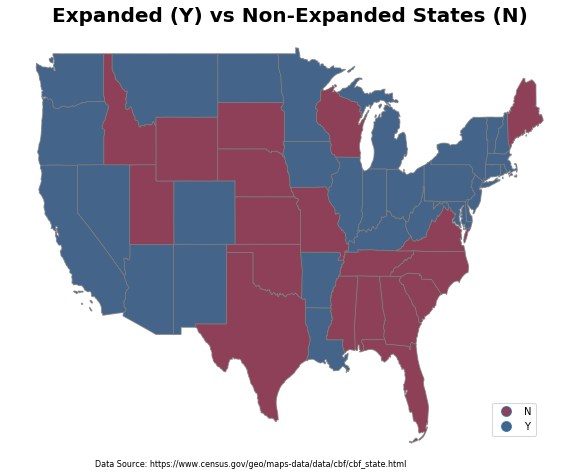

In [30]:
fig, ax = plt.subplots(figsize = (10,8))

usa_map2.plot(ax = ax, 
             edgecolor='grey', # State border color
             column='State_Expanded_Medicaid', # Shade the map based on this column
             cmap='RdBu', # Color map scheme
             alpha = 0.75, # Opacity
             legend=True)  # Legend is visible

ax.set_title("Expanded (Y) vs Non-Expanded States (N)", # Set title
             fontsize=20,  # Set font size
             fontweight="bold") # Make the title bold

# To move the legend from the upper right to lower left corner:
leg = ax.get_legend() # Call the legend
leg.set_bbox_to_anchor((0.75, -0.05, 0.2, 0.2)) # Give desired location

# Here I remove axis labels as well as the box around the map
ax.get_xaxis().set_visible(False)
ax.get_yaxis().set_visible(False)
ax.spines["right"].set_visible(False)
ax.spines["left"].set_visible(False)
ax.spines["top"].set_visible(False)
ax.spines["bottom"].set_visible(False)

# Citing the location of the shape file:
ax.text(-118,23,  # Text location
        "Data Source: https://www.census.gov/geo/maps-data/data/cbf/cbf_state.html", # Text
        fontsize=8) # Text size
plt.show()

This is a nice way to visualize which of the continental US states have expanded Medicaid. Now I want to get into the actual spending data.

### 2. Census Data

For the census data I am only interested in retreiving state population so that I can normalize spending per person later on. Here I just grab that data:

In [31]:
api_key = 'eb8986b23067b8be3dabb06a104157a088a772bd'
# This the api key I received

c = Census(api_key)
# This will create an object c which has methods associated with it so I can pull the data I need

In [32]:
code = ("NAME","B01001_001E") 
# NAME is the state name, and  B01001_001E is the population. 

In [33]:
state_pop_2016 = c.acs5.get(code, {'for': 'state:* '}, year=2016)
# I am grabbing the state name and population for 2016 from the American Community Survey

state_pop_2016 = pd.DataFrame(state_pop_2016)
# And converting this information into a dataframe

print(state_pop_2016.shape)

state_pop_2016.tail()

(52, 3)


,B01001_001E,NAME,state
47,7073146,Washington,53
48,1846092,West Virginia,54
49,5754798,Wisconsin,55
50,583029,Wyoming,56
51,3529385,Puerto Rico,72


In [34]:
state_pop_2016.drop(51, inplace=True)

# There are 52 rather than 51 entries. This is because Puerto Rico's population has been included
# Since I do not have other information on Puerto Rico, I will drop it again

In [35]:
state_pop_2016.columns = ["Population", "State", "State_Code"]

# Here I am renaming the columns. Population replaces the number, 
# NAME becomes State so I can merge on this column, and I change state to State_Code to avoid repetition.

In [36]:
state_pop_2016.head()

,Population,State,State_Code
0,4841164,Alabama,01
1,736855,Alaska,02
2,6728577,Arizona,04
3,2968472,Arkansas,05
4,38654206,California,06


In [37]:
state_pop_2016.dtypes

# The last thing to note is that I want to eventually divide by Population, 
# so it needs to be recognized as a number rather than an object.

Population    object
State         object
State_Code    object
dtype: object

In [38]:
state_pop_2016["Population"] = state_pop_2016["Population"].astype(float, inplace = True)

# Here I convert Population to a float

In [39]:
state_pop_2016.dtypes

Population    float64
State          object
State_Code     object
dtype: object

### 3. State Drug Utilization Data

This data was more difficult to read into my notebook than anticipated due to its large size. When I tried to read in multiple years of data at once, my computer would slow and eventually freeze. Therefore, I have a separate notebook where I clean and combine this data. It is called SDU_Data_Cleaning and is located in the [SDU_Data folder](https://github.com/Davina-Francki/Data_Bootcamp_Final_Project/tree/master/SDU_Data) in my repository. It is a bit time-consuming, so I here I will only have an example with one year to demonstrate the process. All of the work can be found in the other notebook.

In [40]:
# I created an account with Socrata that gives me full access to data on Medicaid.gov
# Here I use the Socrata package to grab the 2017 State Drug Utilization data

client = Socrata("data.medicaid.gov",                 # The website that hosts the data
                  "vK40fQCmmsCNjgjfTJ7IfcvGF",        # My access key
                  username="df1559@stern.nyu.edu",    # Account username
                  password="OmaDeda0904*")            # Account password

# I then read in the specific data

results = client.get("f8sh-7iwd",                               # This is the specific code for the 2017 data
                     where = "medicaid_amount_reimbursed > 0",  # I only want entries where drugs were actually 
                                                                # reimbursed by Medicaid
                     order = "state_code ASC",                  # I then order the rows based on state name
                     limit = 3000000)                           # The default is 1000, so to get all entries I need
                                                                # to put in a large number. There are over 4M rows but
                                                                # this drops to below 3M with the "where" specification

# Finally I convert it to a dataframe
results_df = pd.DataFrame.from_records(results)

In [41]:
results_df.head(10)

,_latitude,_longitude,_quarter_begin,_quarter_begin_date,labeler_code,location,medicaid_amount_reimbursed,ndc,non_medicaid_amount_reimbursed,number_of_prescriptions,package_size,period_covered,product_code,product_fda_list_name,quarter,state_code,suppression_used,total_amount_reimbursed,units_reimbursed,utilization_type
0,61.385,-152.2683,7/1,2017-07-01T00:00:00.000,00603,"{'type': 'Point', 'coordinates': [-152.2683, 6...",5410.51,00603763417,0,121,17,2017,7634,ORSYTHIA,3,AK,False,5410.51,8400,FFSU
1,61.385,-152.2683,7/1,2017-07-01T00:00:00.000,27241,"{'type': 'Point', 'coordinates': [-152.2683, 6...",3010.2,27241005303,62.57,98,03,2017,0053,ARIPIPRAZO,3,AK,False,3072.77,2578,FFSU
2,61.385,-152.2683,7/1,2017-07-01T00:00:00.000,00169,"{'type': 'Point', 'coordinates': [-152.2683, 6...",1311.52,00169183302,0,30,02,2017,1833,NOVOLIN R,3,AK,False,1311.52,360,FFSU
3,61.385,-152.2683,4/1,2017-04-01T00:00:00.000,00054,"{'type': 'Point', 'coordinates': [-152.2683, 6...",37610.29,00054327099,86.88,2193,99,2017,3270,FLUTICASON,2,AK,False,37697.17,34720.8,FFSU
4,61.385,-152.2683,10/1,2017-10-01T00:00:00.000,00093,"{'type': 'Point', 'coordinates': [-152.2683, 6...",252.04,00093083205,0,42,05,2017,0832,CLONAZEPAM,4,AK,False,252.04,2116,FFSU
5,61.385,-152.2683,4/1,2017-04-01T00:00:00.000,68645,"{'type': 'Point', 'coordinates': [-152.2683, 6...",511.91,68645015054,0,48,54,2017,0150,GLIPIZIDE,2,AK,False,511.91,4830,FFSU
6,61.385,-152.2683,7/1,2017-07-01T00:00:00.000,16714,"{'type': 'Point', 'coordinates': [-152.2683, 6...",90.7,16714045201,0,21,01,2017,0452,QUETIAPINE,3,AK,False,90.7,604,FFSU
7,61.385,-152.2683,10/1,2017-10-01T00:00:00.000,00603,"{'type': 'Point', 'coordinates': [-152.2683, 6...",405.19,00603243421,0,33,21,2017,2434,BENZTROPIN,4,AK,False,405.19,696,FFSU
8,61.385,-152.2683,7/1,2017-07-01T00:00:00.000,00527,"{'type': 'Point', 'coordinates': [-152.2683, 6...",1955.44,00527133701,0,57,01,2017,1337,BACLOFEN,3,AK,False,1955.44,3790,FFSU
9,61.385,-152.2683,10/1,2017-10-01T00:00:00.000,59676,"{'type': 'Point', 'coordinates': [-152.2683, 6...",91249.41,59676056630,0,67,30,2017,0566,PREZISTA,4,AK,False,91249.41,2004,FFSU


In [42]:
results_df.shape
# It is a very large dataset

(2239848, 20)

In [43]:
# Here I drop the columns that are not necessary in my analysis
results_df.drop(["_quarter_begin",
            "_quarter_begin_date",
            "labeler_code", 
            "location",  
            "ndc",
            "number_of_prescriptions",
            "package_size", 
            "product_code",
            "product_fda_list_name",
            "quarter", 
            "suppression_used",
            "utilization_type"], axis=1, inplace = True)

I noticed that states are represented by their abbreviation rather than their full name. However, in the census and expansion datasets the full names are used. To merge later on I need to convert the abbreviations to full names. Luckily I found a dictionary on [GitHub](https://gist.github.com/rogerallen/1583593) that converts codes to names. Here I read it in:

In [44]:
us_state_abbrev = {
    'AL': 'Alabama',
    'AK': 'Alaska',
    'AZ': 'Arizona',
    'AR': 'Arkansas',
    'CA': 'California',
    'CO': 'Colorado',
    'CT': 'Connecticut',
    'DE': 'Delaware',
    'FL': 'Florida',
    'GA': 'Georgia',
    'HI': 'Hawaii',
    'ID': 'Idaho',
    'IL': 'Illinois',
    'IN': 'Indiana',
    'IA': 'Iowa',
    'KS': 'Kansas',
    'KY': 'Kentucky',
    'LA': 'Louisiana',
    'ME': 'Maine',
    'MD': 'Maryland',
    'MA': 'Massachusetts',
    'MI': 'Michigan',
    'MN': 'Minnesota',
    'MS': 'Mississippi',
    'MO': 'Missouri',
    'MT': 'Montana',
    'NE': 'Nebraska',
    'NV': 'Nevada',
    'NH': 'New Hampshire',
    'NJ': 'New Jersey',
    'NM': 'New Mexico',
    'NY': 'New York',
    'NC': 'North Carolina',
    'ND': 'North Dakota',
    'OH': 'Ohio',
    'OK': 'Oklahoma',
    'OR': 'Oregon',
    'PA': 'Pennsylvania',
    'RI': 'Rhode Island',
    'SC': 'South Carolina',
    'SD': 'South Dakota',
    'TN': 'Tennessee',
    'TX': 'Texas',
    'UT': 'Utah',
    'VT': 'Vermont',
    'VA': 'Virginia',
    'WA': 'Washington',
    'WV': 'West Virginia',
    'WI': 'Wisconsin',
    'WY': 'Wyoming',
}

In [45]:
results_df.state_code.replace(to_replace = us_state_abbrev, inplace = True)
# Here I replace the codes with the full names by passing through the dictionary

In [46]:
results_df.head()

,_latitude,_longitude,medicaid_amount_reimbursed,non_medicaid_amount_reimbursed,period_covered,state_code,total_amount_reimbursed,units_reimbursed
0,61.385,-152.2683,5410.51,0,2017,Alaska,5410.51,8400
1,61.385,-152.2683,3010.2,62.57,2017,Alaska,3072.77,2578
2,61.385,-152.2683,1311.52,0,2017,Alaska,1311.52,360
3,61.385,-152.2683,37610.29,86.88,2017,Alaska,37697.17,34720.8
4,61.385,-152.2683,252.04,0,2017,Alaska,252.04,2116


In [47]:
results_df.dtypes

# To perform operations on spending later on I need to convert it from an object to a number

_latitude                         object
_longitude                        object
medicaid_amount_reimbursed        object
non_medicaid_amount_reimbursed    object
period_covered                    object
state_code                        object
total_amount_reimbursed           object
units_reimbursed                  object
dtype: object

In [48]:
results_df["medicaid_amount_reimbursed"] = results_df["medicaid_amount_reimbursed"].astype(float, inplace = True)
# Here I convert the amount reimbursed to a float

Now I want to find the total amount reimbursed for each state in the year 2017. I am looking at total spending on drugs rather than the specific drugs themselves.

In [49]:
new = results_df.groupby("state_code")
# First I group by the state

In [50]:
totals_2017 = new["medicaid_amount_reimbursed"].sum()
# Then I create a new series that represents the total amount spent by each state

In [51]:
totals_2017_final  = totals_2017.drop("XX")
# I then drop the national totals so I can make a bar chart with the totals.
# The national amount stretches the graph

In [52]:
totals_2017_final

state_code
Alabama           6.787368e+08
Alaska            1.375169e+08
Arizona           1.121780e+09
Arkansas          3.656795e+08
California        7.160615e+09
Colorado          9.050236e+08
Connecticut       1.216403e+09
DC                2.858465e+08
Delaware          2.963721e+06
Florida           2.941874e+09
Georgia           1.143579e+09
Hawaii            1.550418e+08
Idaho             1.919831e+08
Illinois          1.792826e+09
Indiana           1.388079e+09
Iowa              2.949533e+08
Kansas            3.256777e+08
Kentucky          1.133654e+09
Louisiana         1.046648e+09
Maine             2.220872e+08
Maryland          1.120351e+09
Massachusetts     1.378799e+09
Michigan          2.064807e+09
Minnesota         8.962187e+08
Mississippi       4.400233e+08
Missouri          1.228983e+09
Montana           2.089759e+08
Nebraska          1.591421e+08
Nevada            4.566977e+08
New Hampshire     9.527102e+07
New Jersey        1.309827e+09
New Mexico        4.135401e+

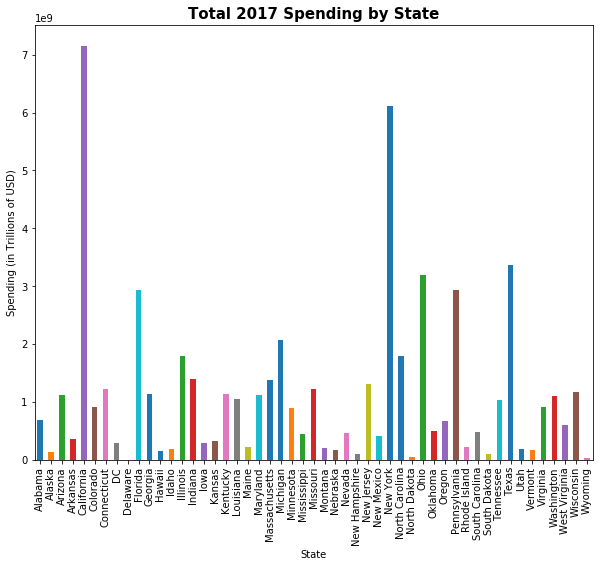

In [53]:
fig, ax = plt.subplots(figsize=(10,8))

totals_2017_final.plot.bar(ax=ax)

ax.set_title("Total 2017 Spending by State", fontsize=15, fontweight="bold") # Set the title
ax.set_ylabel("Spending (in Trillions of USD)") # Set the y label
ax.set_xlabel("State") # Set the x label

plt.show()

Of course large states such as California, New York, and Texas spend more due to their large populations. This is why I will combine this data with census data below. Having per capita spending will make for a better comparison. It is difficult to make any clear conclusions from this data alone.

In [54]:
totals_2017.to_csv("totals_2017.csv")
# Finally I save the totals_2017 series as a csv file so I can combine it with other years
# When I tried to combine all years in jupyter notebook, my computer would crash and I would have to start again
# This way I could go through each year and make sure I had the data I needed

I then repeat this for each year. I struggled to come up with an automated function that would do these steps for each year.

Here I will upload the final combined file, [SDU_State_Totals.xlsx](https://github.com/Davina-Francki/Data_Bootcamp_Final_Project/blob/master/SDU_Data/SDU_State_Totals.xlsx), from my folder. This file is in the [SDU_Data folder](https://github.com/Davina-Francki/Data_Bootcamp_Final_Project/tree/master/SDU_Data) in my repository.

In [55]:
SDU_totals = pd.read_excel("SDU_State_Totals.xlsx")

In [56]:
SDU_totals.head(10)

# Each year represents the total spending at the state level

,State,2010,2011,2012,2013,2014,2015,2016,2017
0,Alabama,4.791182e+08,4.923865e+08,4.969177e+08,5.136298e+08,5.500689e+08,6.193552e+08,6.673464e+08,6.787368e+08
1,Alaska,1.211837e+08,1.651983e+08,1.125291e+08,1.394358e+08,5.876672e+07,7.341019e+07,1.085943e+08,1.375169e+08
2,Arizona,4.768952e+08,7.171098e+08,4.688066e+08,6.136353e+08,6.934896e+08,9.577278e+08,1.246118e+09,1.121780e+09
3,Arkansas,3.110965e+08,3.119547e+08,3.089601e+08,3.059460e+08,3.518599e+08,3.496528e+08,3.397857e+08,3.656795e+08
4,California,3.672208e+09,3.953023e+09,3.660938e+09,3.790730e+09,5.128928e+09,7.131050e+09,8.004575e+09,7.160615e+09
5,Colorado,2.518429e+08,3.041606e+08,3.336433e+08,3.752535e+08,5.796412e+08,7.591099e+08,9.088009e+08,9.050236e+08
6,Connecticut,5.064009e+08,6.045097e+08,6.619327e+08,6.763782e+08,9.067386e+08,1.162626e+09,1.245734e+09,1.216403e+09
7,DC,6.728187e+07,1.086528e+08,1.920560e+08,1.021842e+08,1.198916e+08,1.454308e+08,2.581744e+08,2.858465e+08
8,Delaware,1.271308e+08,1.489894e+08,1.708165e+08,1.687547e+08,1.937483e+08,2.046680e+08,1.755537e+08,2.963721e+06
9,Florida,1.507242e+09,1.799638e+09,1.851466e+09,1.986922e+09,2.350233e+09,2.638117e+09,2.820646e+09,2.941874e+09


In [57]:
SDU_totals["State"].replace({"DC": "District of Columbia"}, inplace=True)

# I noticed that Washington DC was displayed as District of Columbia in the census and expansion data sets.
# Here I am changing DC to District of Columbia so it will merge correctly later on

In [58]:
SDU_totals.head(10)

,State,2010,2011,2012,2013,2014,2015,2016,2017
0,Alabama,4.791182e+08,4.923865e+08,4.969177e+08,5.136298e+08,5.500689e+08,6.193552e+08,6.673464e+08,6.787368e+08
1,Alaska,1.211837e+08,1.651983e+08,1.125291e+08,1.394358e+08,5.876672e+07,7.341019e+07,1.085943e+08,1.375169e+08
2,Arizona,4.768952e+08,7.171098e+08,4.688066e+08,6.136353e+08,6.934896e+08,9.577278e+08,1.246118e+09,1.121780e+09
3,Arkansas,3.110965e+08,3.119547e+08,3.089601e+08,3.059460e+08,3.518599e+08,3.496528e+08,3.397857e+08,3.656795e+08
4,California,3.672208e+09,3.953023e+09,3.660938e+09,3.790730e+09,5.128928e+09,7.131050e+09,8.004575e+09,7.160615e+09
5,Colorado,2.518429e+08,3.041606e+08,3.336433e+08,3.752535e+08,5.796412e+08,7.591099e+08,9.088009e+08,9.050236e+08
6,Connecticut,5.064009e+08,6.045097e+08,6.619327e+08,6.763782e+08,9.067386e+08,1.162626e+09,1.245734e+09,1.216403e+09
7,District of Columbia,6.728187e+07,1.086528e+08,1.920560e+08,1.021842e+08,1.198916e+08,1.454308e+08,2.581744e+08,2.858465e+08
8,Delaware,1.271308e+08,1.489894e+08,1.708165e+08,1.687547e+08,1.937483e+08,2.046680e+08,1.755537e+08,2.963721e+06
9,Florida,1.507242e+09,1.799638e+09,1.851466e+09,1.986922e+09,2.350233e+09,2.638117e+09,2.820646e+09,2.941874e+09


These numbers are a bit hard to read, so I am going to convert them into millions of dollars:

In [59]:
col_list = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]

# First, I make a list of columns I would like to divide into

SDU_totals[col_list] = SDU_totals[col_list]/1000000

# Then I divide by one million

In [60]:
SDU_totals.head()

# Easier to read now

,State,2010,2011,2012,2013,2014,2015,2016,2017
0,Alabama,479.118248,492.386468,496.917747,513.629814,550.068851,619.355202,667.346361,678.736779
1,Alaska,121.183707,165.198293,112.529058,139.435835,58.766720,73.410185,108.594349,137.516860
2,Arizona,476.895244,717.109818,468.806641,613.635309,693.489620,957.727754,1246.118344,1121.780420
3,Arkansas,311.096525,311.954713,308.960128,305.946015,351.859884,349.652775,339.785707,365.679482
4,California,3672.208309,3953.023102,3660.937862,3790.730201,5128.927855,7131.050190,8004.575487,7160.615277


Now I can look at general trends across states. To do this I set the index and look at the basic statistics

In [61]:
SDU_totals_2 = SDU_totals.set_index("State")

In [62]:
SDU_totals_2.describe()

,2010,2011,2012,2013,2014,2015,2016,2017
count,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000,52.000000
mean,1241.506060,1418.573190,1418.625824,1409.829896,1753.963104,2068.048651,2302.758342,2283.663045
std,4566.613384,5219.954455,5236.572661,5234.227605,6495.199298,7679.727933,8567.214136,8533.095007
min,29.275011,31.637870,30.630002,29.391887,31.519273,33.762871,34.157622,2.963721
25%,139.874710,170.867378,185.826087,156.226460,199.045554,222.657241,247.863222,221.260532
50%,378.506443,492.319872,417.165098,411.198249,564.855035,751.685991,762.804723,787.477718
75%,741.749342,766.259735,847.754201,823.300137,1012.129427,1147.660698,1260.702566,1249.193916
max,32989.906942,37783.429302,37976.860400,37940.450110,47078.114992,55620.114965,62016.683227,61826.407221


Looking at the results:
* It looks like average spending dropped a bit in 2013 but increased in 2014. This could be due to the Medicaid expansion. The general trend for average spending is that it is increaseing as spending has increased over time from around 1240 million USD to about 2280 million USD.
* The minimum value in 2017 is extremely low compared to the other years. This is something I might look out for later on. However, the minimum always seems to be in the 30 million USD to 35 million USD range. This could mean that states that spend lower amounts before expansion have chosen to continue with these amounts by choosing not to expand coverage.
* Finally, the max value always represents the national total, which has almost doubled from 2010 to 2017. Let us look at the national trend in more detail.

In [63]:
national = SDU_totals_2.loc["XX"]

# In the data set the row XX represents national totals
# I am locking down that value so I can look at it

In [64]:
national

2010    32989.906942
2011    37783.429302
2012    37976.860400
2013    37940.450110
2014    47078.114992
2015    55620.114965
2016    62016.683227
2017    61826.407221
Name: XX, dtype: float64

Now I plot national spending over time:

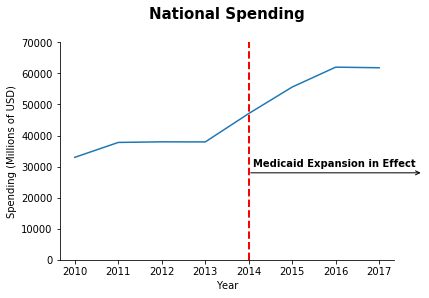

In [65]:
fig, ax = plt.subplots()

national.plot(ax=ax) # Plotting national spending over the years

# Making clearer x labels and setting them:
xlabel_list = ["0","2010", "2011", "2012", "2013",
              "2014", "2015", "2016", "2017"] 
ax.set_xticklabels(xlabel_list)

ax.set_title("National Spending\n",   # Set the title
            fontsize=15,              # Make the title bigger
            fontweight="bold")        # Make it bold

ax.set_ylabel("Spending (Millions of USD)") # Set the y label
ax.set_xlabel("Year") # Set the x label

ax.set_ylim(0, 70000) # Set the limits of the y axis

# Remove upper and right boundaries of graph:
ax.spines["right"].set_visible(False) 
ax.spines["top"].set_visible(False)

# To mark the year Medicaid expansion went into effect:
ax.axvline(x=4,           # Set the value to correspond to 2014
           color='r',       # make the color red
           linestyle='--',   # the line style
           linewidth=2)     # thickness of the line

# I then create a label for the line
message = "Medicaid Expansion in Effect"
ax.text(4.1, 30000,                 # Where the message begins
        message,                    # The text is the above message
        horizontalalignment='left', # It will be on the left
        fontweight="bold")          # Bold the text

# Finally I want a line marking the expansion phase:
ax.annotate("",            # There's no message
            xy=(4, 28000), # Line starts here
            xytext=(8, 28000), # Line ends here
            arrowprops=dict(arrowstyle="<-")) # Type of arrow
plt.show()

It looks like the jump in national spending occurs from 2013 to 2014, which means coincides with Medicaid expansion. Spending also continues to increase from 2014 to about 2016, so there could be some other factors at play. This is in great contrast to the years 2011 to 2013, where spending is almost flat. The plateau from 2016 to 2017 could be associated with the US presidential elections and changes in policy. 

Do these trends apply to per capita spending as well? To find out I simply divide the totals by the US population, which is about 325.7 million.

In [66]:
national_pc = national/325700000

In [67]:
national_pc_final = national_pc*1000000

# Change from millions of dollars to just dollars

In [68]:
national_pc_final

# Looks like the jump from 2013 to 2014 applies here as well

2010    101.289245
2011    116.006845
2012    116.600738
2013    116.488947
2014    144.544412
2015    170.771001
2016    190.410449
2017    189.826243
Name: XX, dtype: float64

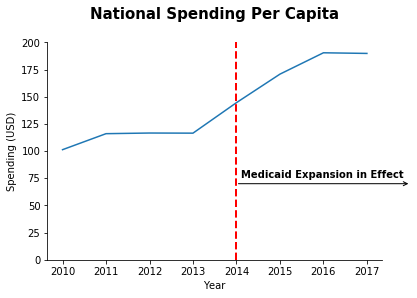

In [69]:
fig, ax = plt.subplots()

national_pc_final.plot(ax=ax) # Plotting national spending over the years

# Making clearer x labels and setting them:
xlabel_list = ["0","2010", "2011", "2012", "2013",
              "2014", "2015", "2016", "2017"] 
ax.set_xticklabels(xlabel_list)

ax.set_title("National Spending Per Capita\n", # Set the title
             fontsize=15,                      # Set the font size
             fontweight="bold")                # Make the text bold

ax.set_ylabel("Spending (USD)") # Set the y label
ax.set_xlabel("Year") # Set the x label

ax.set_ylim(0, 200) # Set the limits of the y axis

# Remove upper and right boundaries of graph:
ax.spines["right"].set_visible(False) 
ax.spines["top"].set_visible(False)

# To mark the year Medicaid expansion went into effect:
ax.axvline(x=4,             # Set the value to correspond to 2014
           color='r',       # make the color red
           linestyle='--',  # the line style
           linewidth=2)     # thickness of the line

# I then create a label for the line
message = "Medicaid Expansion in Effect"

ax.text(4.1, 75,                    # Where the message begins
        message,                    # The text is the above message
        horizontalalignment='left', # It will be on the left
        fontweight="bold")          # Bold the text

ax.annotate("",              # There's no message
            xy=(4, 70),      # Line starts here
            xytext=(8, 70),  # Line ends here
            arrowprops=dict(arrowstyle="<-"))  # Type of line

plt.show()

Looks like the trend of increased spending around 2014 applies to per capita spending as well. Now I will see if this relates to Medicaid expansion by comparing states that have and have not expanded Medicaid.

### Bringing the Data Together

Here I combine the three sets of data and clean up the resulting data frame.

In [70]:
final_df = SDU_totals.merge(state_pop_2016.merge(expansion_df_final, on="State", how = "left"), on="State", how="left")

# First I merge the expansion data frame with the census data frame on the column "State"
# I then take this merged set and merge it with the SDU data on the same column

In [71]:
final_df.head()

,State,2010,2011,2012,2013,2014,2015,2016,2017,Population,State_Code,Report_Date,State_Expanded_Medicaid
0,Alabama,479.118248,492.386468,496.917747,513.629814,550.068851,619.355202,667.346361,678.736779,4841164.0,01,2018-02-01T00:00:00.000,N
1,Alaska,121.183707,165.198293,112.529058,139.435835,58.766720,73.410185,108.594349,137.516860,736855.0,02,2018-02-01T00:00:00.000,Y
2,Arizona,476.895244,717.109818,468.806641,613.635309,693.489620,957.727754,1246.118344,1121.780420,6728577.0,04,2018-02-01T00:00:00.000,Y
3,Arkansas,311.096525,311.954713,308.960128,305.946015,351.859884,349.652775,339.785707,365.679482,2968472.0,05,2018-02-01T00:00:00.000,Y
4,California,3672.208309,3953.023102,3660.937862,3790.730201,5128.927855,7131.050190,8004.575487,7160.615277,38654206.0,06,2018-02-01T00:00:00.000,Y


Now I want to create columns that show the per capita spending of each state every year:

In [72]:
new_columns = ["2010_pc", "2011_pc", "2012_pc", "2013_pc", "2014_pc", "2015_pc", "2016_pc", "2017_pc"]

# First, I make a list of new column names. They will contain the per capita spending for each year

current_columns = ["2010", "2011", "2012", "2013", "2014", "2015", "2016", "2017"]

# Next I create a list of the current columns I want divided by population

final_df[new_columns]=final_df[current_columns].div(final_df.Population, axis=0) 

# Here I am dividing the list of current columns by population to create the new columns

In [73]:
final_df.columns

# However, the new columns are at the end and I would prefer them next to each year

Index(['State', '2010', '2011', '2012', '2013', '2014', '2015', '2016', '2017',
       'Population', 'State_Code', 'Report_Date', 'State_Expanded_Medicaid',
       '2010_pc', '2011_pc', '2012_pc', '2013_pc', '2014_pc', '2015_pc',
       '2016_pc', '2017_pc'],
      dtype='object')

In [74]:
final_df = final_df[['State', '2010', '2010_pc', '2011','2011_pc', '2012', '2012_pc', '2013','2013_pc', 
              '2014','2014_pc', '2015','2015_pc', '2016','2016_pc', '2017','2017_pc',
              'Population', 'State_Code', 'Report_Date', 'State_Expanded_Medicaid']]

# Here I rearrange the columns

In [75]:
final_df.drop("Report_Date", axis = 1, inplace = True)

# I am also dropping the Report_Date column since I no longer need it

final_df.head()

# Now I can start analyzing the data

,State,2010,2010_pc,2011,2011_pc,2012,2012_pc,2013,2013_pc,2014,2014_pc,2015,2015_pc,2016,2016_pc,2017,2017_pc,Population,State_Code,State_Expanded_Medicaid
0,Alabama,479.118248,0.000099,492.386468,0.000102,496.917747,0.000103,513.629814,0.000106,550.068851,0.000114,619.355202,0.000128,667.346361,0.000138,678.736779,0.000140,4841164.0,01,N
1,Alaska,121.183707,0.000164,165.198293,0.000224,112.529058,0.000153,139.435835,0.000189,58.766720,0.000080,73.410185,0.000100,108.594349,0.000147,137.516860,0.000187,736855.0,02,Y
2,Arizona,476.895244,0.000071,717.109818,0.000107,468.806641,0.000070,613.635309,0.000091,693.489620,0.000103,957.727754,0.000142,1246.118344,0.000185,1121.780420,0.000167,6728577.0,04,Y
3,Arkansas,311.096525,0.000105,311.954713,0.000105,308.960128,0.000104,305.946015,0.000103,351.859884,0.000119,349.652775,0.000118,339.785707,0.000114,365.679482,0.000123,2968472.0,05,Y
4,California,3672.208309,0.000095,3953.023102,0.000102,3660.937862,0.000095,3790.730201,0.000098,5128.927855,0.000133,7131.050190,0.000184,8004.575487,0.000207,7160.615277,0.000185,38654206.0,06,Y


## Analyzing the Data

My main objective is to see whether or not a state expanding Medicaid has an effect on its spending over time. The expansion went into effect in 2014, so I want to compare spending before and after this point in time.

In [76]:
final_df.set_index("State", inplace=True)
# I am going to set the index to the state name
final_df.head()

,2010,2010_pc,2011,2011_pc,2012,2012_pc,2013,2013_pc,2014,2014_pc,2015,2015_pc,2016,2016_pc,2017,2017_pc,Population,State_Code,State_Expanded_Medicaid
State,,,,,,,,,,,,,,,,,,,
Alabama,479.118248,0.000099,492.386468,0.000102,496.917747,0.000103,513.629814,0.000106,550.068851,0.000114,619.355202,0.000128,667.346361,0.000138,678.736779,0.000140,4841164.0,01,N
Alaska,121.183707,0.000164,165.198293,0.000224,112.529058,0.000153,139.435835,0.000189,58.766720,0.000080,73.410185,0.000100,108.594349,0.000147,137.516860,0.000187,736855.0,02,Y
Arizona,476.895244,0.000071,717.109818,0.000107,468.806641,0.000070,613.635309,0.000091,693.489620,0.000103,957.727754,0.000142,1246.118344,0.000185,1121.780420,0.000167,6728577.0,04,Y
Arkansas,311.096525,0.000105,311.954713,0.000105,308.960128,0.000104,305.946015,0.000103,351.859884,0.000119,349.652775,0.000118,339.785707,0.000114,365.679482,0.000123,2968472.0,05,Y
California,3672.208309,0.000095,3953.023102,0.000102,3660.937862,0.000095,3790.730201,0.000098,5128.927855,0.000133,7131.050190,0.000184,8004.575487,0.000207,7160.615277,0.000185,38654206.0,06,Y


In [77]:
final_df_expansion = final_df.groupby("State_Expanded_Medicaid")
# Now I group states that have and haven't expanded Medicaid

In [78]:
final_df_expansion.groups

{'N': Index(['Alabama', 'Florida', 'Georgia', 'Idaho', 'Kansas', 'Maine',
        'Mississippi', 'Missouri', 'Nebraska', 'North Carolina', 'Oklahoma',
        'South Carolina', 'South Dakota', 'Tennessee', 'Texas', 'Utah',
        'Virginia', 'Wisconsin', 'Wyoming'],
       dtype='object', name='State'),
 'Y': Index(['Alaska', 'Arizona', 'Arkansas', 'California', 'Colorado',
        'Connecticut', 'District of Columbia', 'Delaware', 'Hawaii', 'Illinois',
        'Indiana', 'Iowa', 'Kentucky', 'Louisiana', 'Maryland', 'Massachusetts',
        'Michigan', 'Minnesota', 'Montana', 'Nevada', 'New Hampshire',
        'New Jersey', 'New Mexico', 'New York', 'North Dakota', 'Ohio',
        'Oregon', 'Pennsylvania', 'Rhode Island', 'Vermont', 'Washington',
        'West Virginia'],
       dtype='object', name='State')}

In [79]:
# And make separate dataframes for states that expanded
final_df_yes = final_df_expansion.get_group("Y")
# and those that have not
final_df_no = final_df_expansion.get_group("N")
# These dataframes will be used later when plotting

In [80]:
final_df_yes.head()

,2010,2010_pc,2011,2011_pc,2012,2012_pc,2013,2013_pc,2014,2014_pc,2015,2015_pc,2016,2016_pc,2017,2017_pc,Population,State_Code,State_Expanded_Medicaid
State,,,,,,,,,,,,,,,,,,,
Alaska,121.183707,0.000164,165.198293,0.000224,112.529058,0.000153,139.435835,0.000189,58.766720,0.000080,73.410185,0.000100,108.594349,0.000147,137.516860,0.000187,736855.0,02,Y
Arizona,476.895244,0.000071,717.109818,0.000107,468.806641,0.000070,613.635309,0.000091,693.489620,0.000103,957.727754,0.000142,1246.118344,0.000185,1121.780420,0.000167,6728577.0,04,Y
Arkansas,311.096525,0.000105,311.954713,0.000105,308.960128,0.000104,305.946015,0.000103,351.859884,0.000119,349.652775,0.000118,339.785707,0.000114,365.679482,0.000123,2968472.0,05,Y
California,3672.208309,0.000095,3953.023102,0.000102,3660.937862,0.000095,3790.730201,0.000098,5128.927855,0.000133,7131.050190,0.000184,8004.575487,0.000207,7160.615277,0.000185,38654206.0,06,Y
Colorado,251.842917,0.000047,304.160638,0.000057,333.643260,0.000062,375.253468,0.000070,579.641220,0.000108,759.109862,0.000142,908.800937,0.000170,905.023576,0.000169,5359295.0,08,Y


First, I am going to look at individual state totals over time. I want to see if states that have expanded Medicaid have always spent more than states that have not. Some states may allocate more resources to Medicaid than others regardless of expansion. It might even be that states that already spent more on Medicaid had less of an issue expanding coverage. To determine whether or not this is true I want to create bar charts for each year showing individual state spending.

In [81]:
# I start by dropping the national totals, so I am just looking at states
states_final_df = final_df.drop("XX")

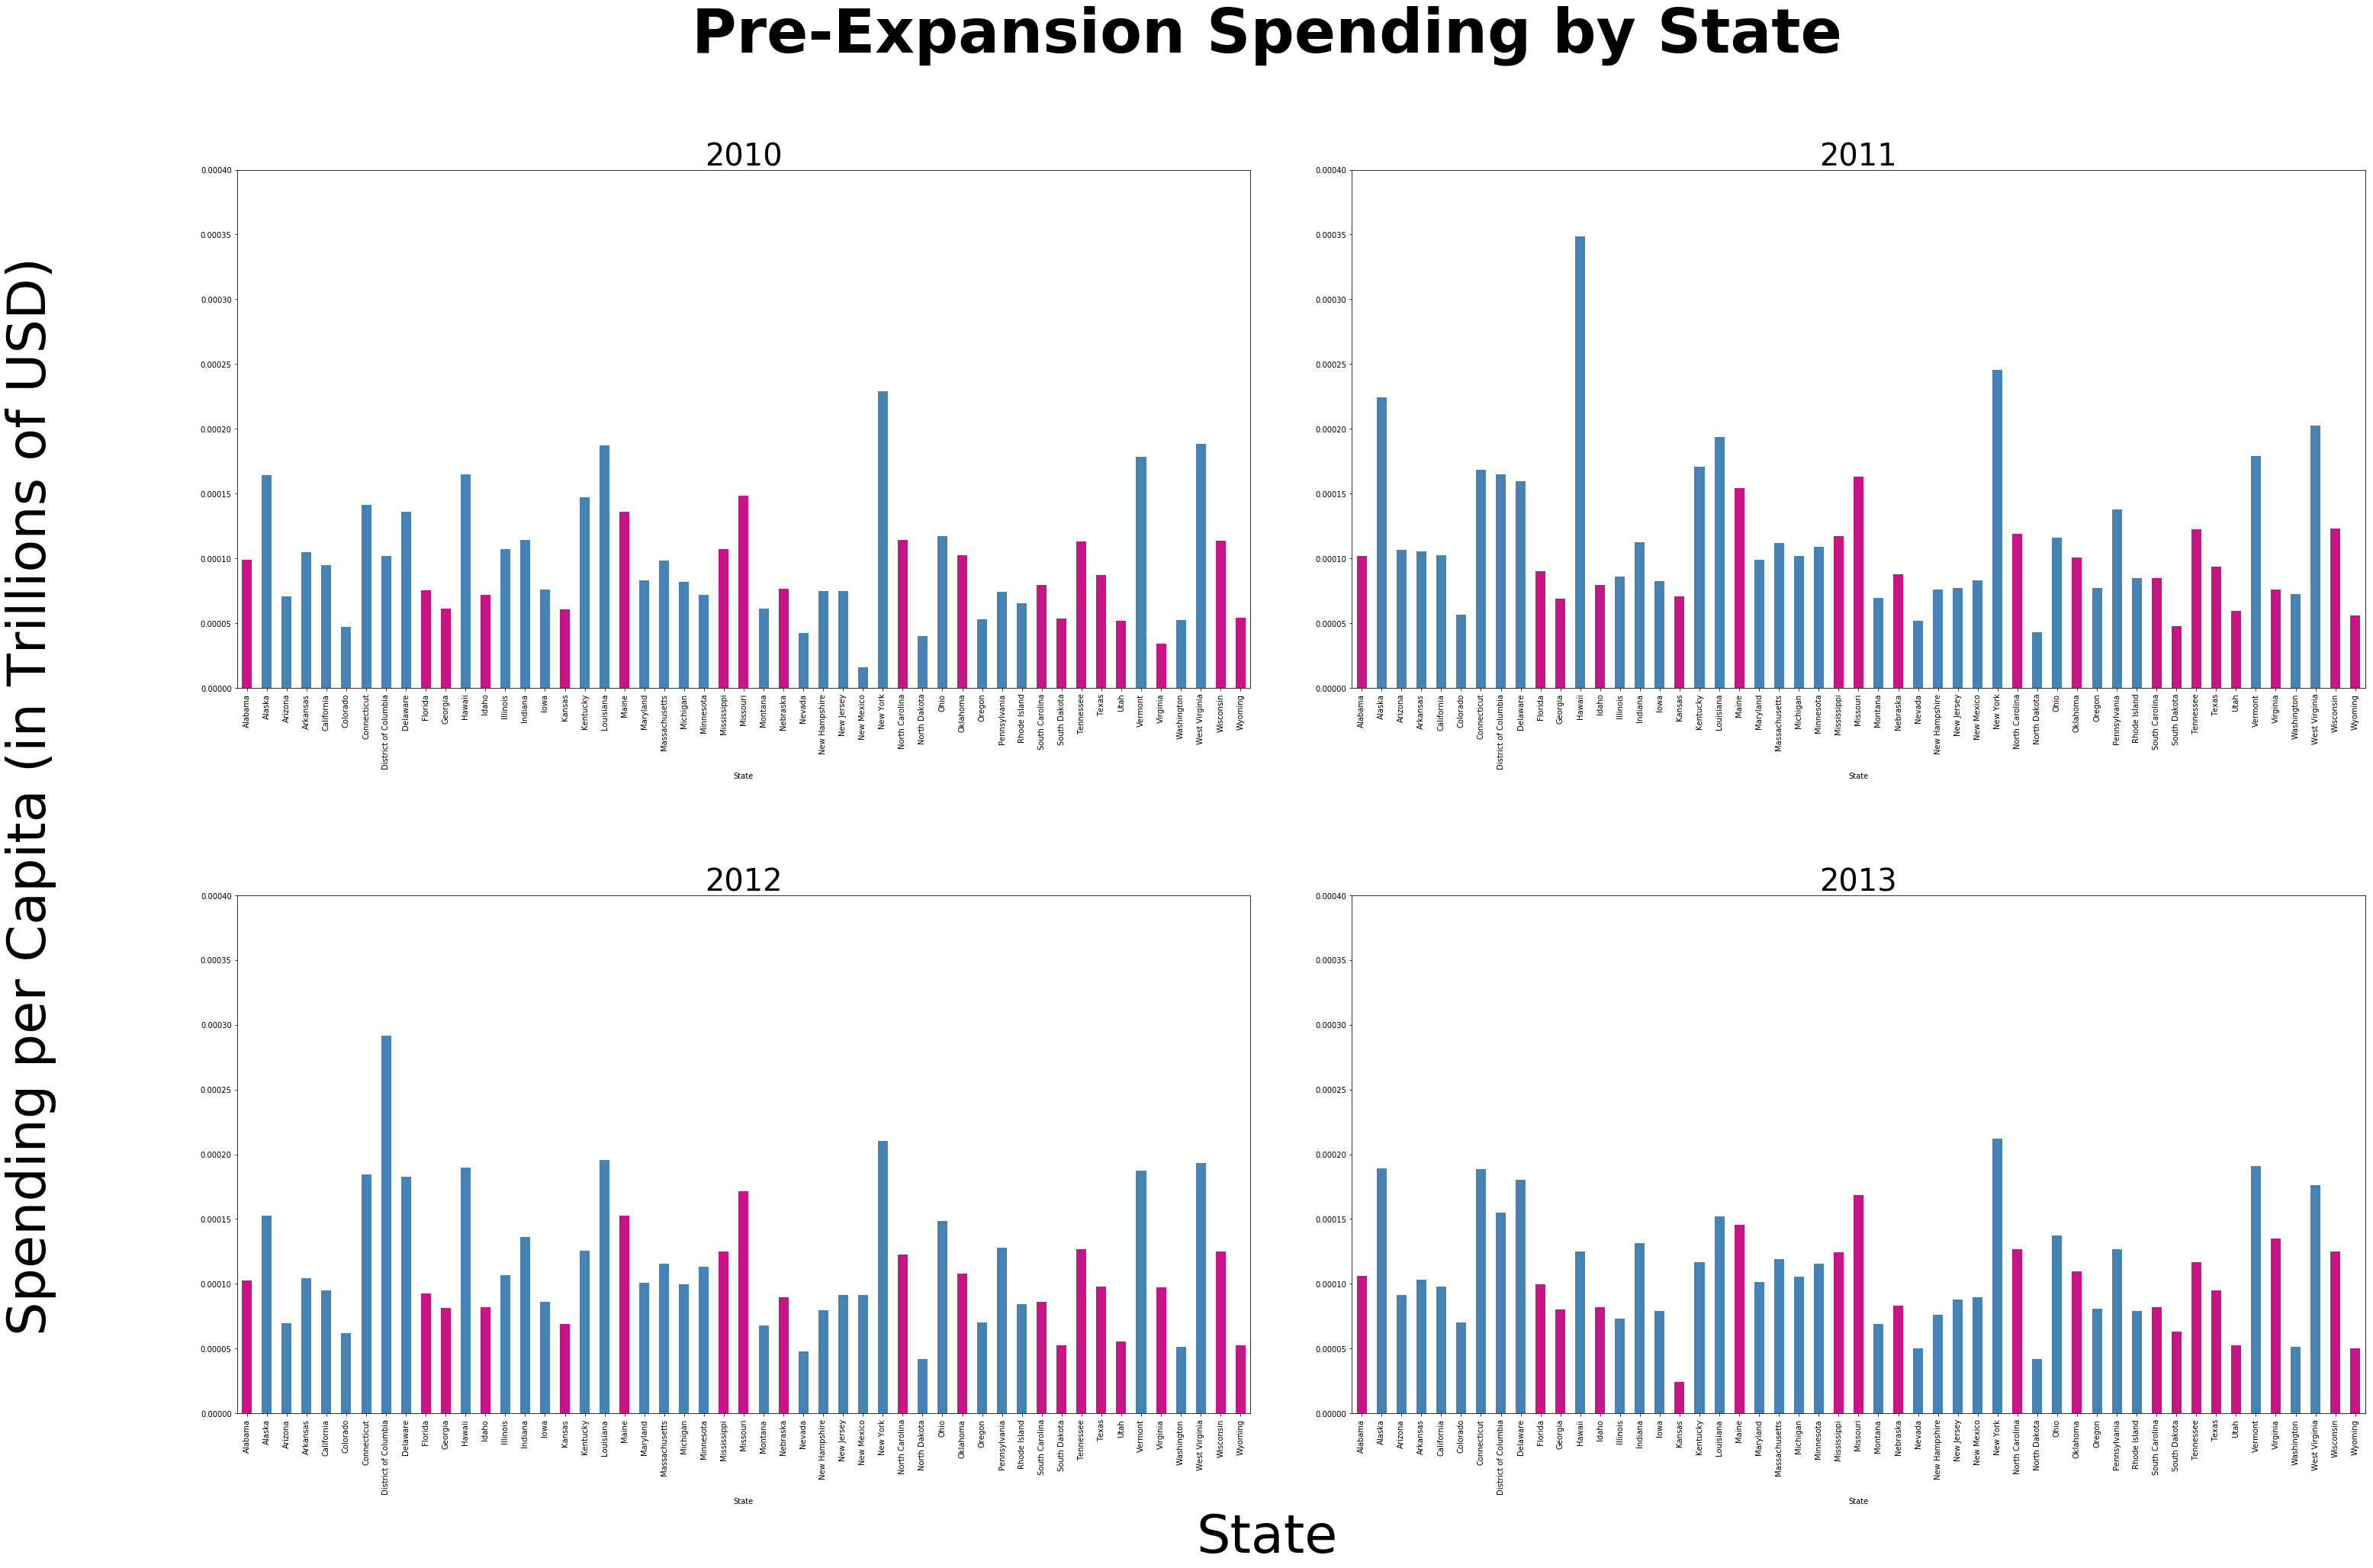

In [92]:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(50,30)) # I am making four plots, as all eight years are too
                                                            # difficult to see

# Formatting the figure itself with subplot spacing and labels:
fig.subplots_adjust(wspace = 0.1,   # The amount of width reserved for blank space between subplots
                    hspace = 0.4)   # The amount of height reserved for white space between subplots

fig.suptitle("Pre-Expansion Spending by State", # Set the figure title
             fontsize = 80,                     # Set the size
             fontweight="bold")                 # Make it bold
# Make x and y labels:
fig.text(0.5,0.05,     # Position of x label
         "State",      # Name of x label
         ha="center",  # It is horizontally centered
         va="center",  # It is verically centered
         fontsize=70)  # Set the size
# Repeat for the y label:
fig.text(0.05,0.5, "Spending per Capita (in Trillions of USD)", ha="center", va="center", rotation=90, fontsize=70)
###################################################################################################################

# I want to shade bars based on expansion information
# So I start by creating lists of states that did and did not expand
# I use the indices of the expansion dataframes I made above
yes_list = final_df_yes.index.tolist()
no_list = final_df_no.index.tolist()

# Then I can make a loop to assign colors to all the bars:
colors = []
for item in states_final_df.index:
    if item in yes_list:
        colors.append('#4682B4') # Steel blue
    else:
        colors.append('#C71585') # Violet red
###################################################################################################################

# Now I plot 2010-2014:
states_final_df["2010_pc"].plot.bar(ax=ax[0,0], color=colors) # Want to plot per capita spending and assign colors
                                                              # based on the list created in the loop above

ax[0,0].set_title("2010", fontsize = 40) # Set the title and its size
ax[0,0].set_ylim(0,0.0004) # I want to specify the y limit so the bars in each graph are comparable

# I repeat this for all the pre-expansion years:

# 2011:
states_final_df["2011_pc"].plot.bar(ax=ax[0,1], color=colors)

ax[0,1].set_title("2011", fontsize = 40)
ax[0,1].set_ylim(0,0.0004)

# 2012:
states_final_df["2012_pc"].plot.bar(ax=ax[1,0], color=colors)

ax[1,0].set_title("2012", fontsize = 40)
ax[1,0].set_ylim(0,0.0004)

# 2013:
states_final_df["2013_pc"].plot.bar(ax=ax[1,1], color=colors)

ax[1,1].set_title("2013", fontsize = 40)
ax[1,1].set_ylim(0,0.0004)

plt.show()

It seems that the states represented by the blue bars (those that will eventually expand Medicaid) already spend more than their non-expansion counterparts. In no one pre-expansion year does a non-expansion state spend more per capita than an expansion state. Therefore, it could be that states the spend more are predisposed to expanding Medicaid. However, to confirm this idea I would have to do more research and look into state-specific policies. 

Since I do not have the data to further look into this trend, I instead turn to the post-expansion years to see if the trend found it the pre-expansion years continues.

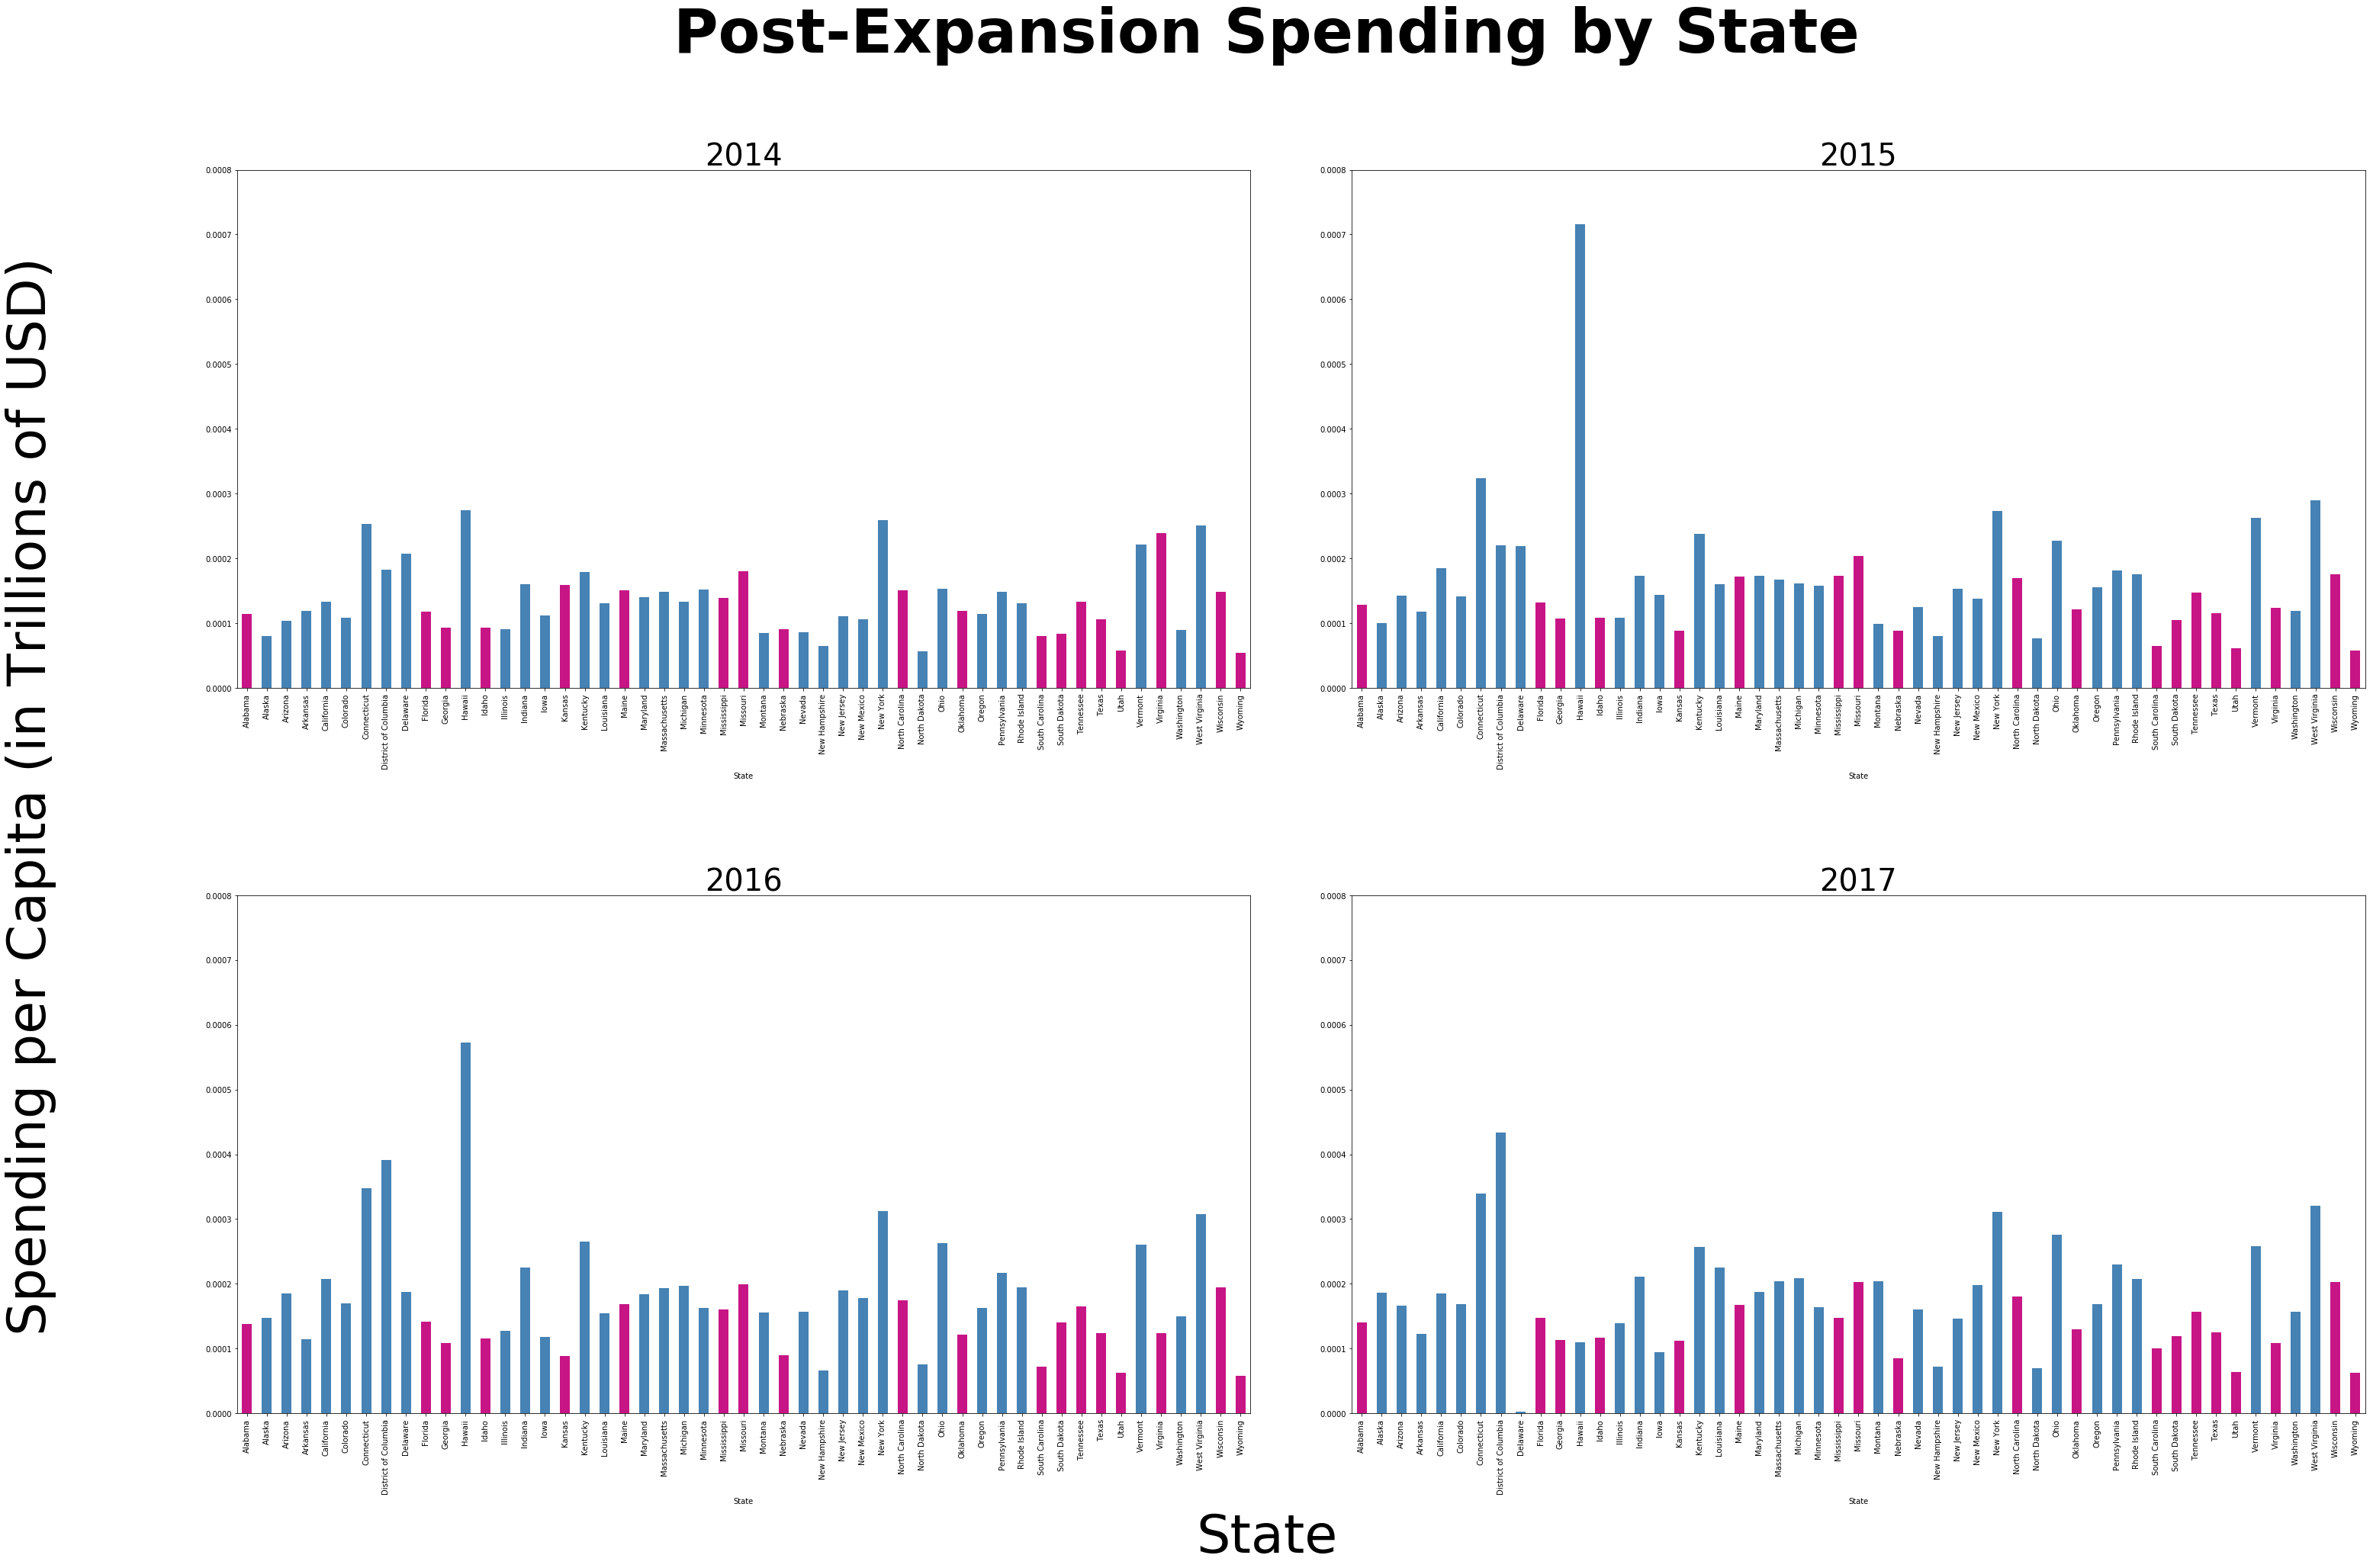

In [93]:
# Now I do the same for the post-expansion years:

# Formatting the figure:
fig, ax = plt.subplots(nrows=2, ncols=2, figsize=(50,30))

fig.subplots_adjust(wspace = 0.1, hspace = 0.4)

fig.suptitle("Post-Expansion Spending by State", fontsize = 80, fontweight="bold") 

fig.text(0.5,0.05, "State", ha="center", va="center", fontsize=70)
fig.text(0.05,0.5, "Spending per Capita (in Trillions of USD)", ha="center", va="center", rotation=90, fontsize=70)

######################################################################################################################

# Repeat the color assignment loop:
colors = []
for item in states_final_df.index:
    if item in yes_list:
        colors.append('#4682B4')
    else:
        colors.append('#C71585')
######################################################################################################################

# Plot individual years:

# 2014:
states_final_df["2014_pc"].plot.bar(ax=ax[0,0], color=colors)

ax[0,0].set_title("2014", fontsize = 40)
ax[0,0].set_ylim(0, 0.0008) # Double the necessary limit for post-expansion charts

# 2015:
states_final_df["2015_pc"].plot.bar(ax=ax[0,1], color=colors)

ax[0,1].set_title("2015", fontsize = 40)
ax[0,1].set_ylim(0, 0.0008)

# 2016:
states_final_df["2016_pc"].plot.bar(ax=ax[1,0], color=colors)

ax[1,0].set_title("2016", fontsize = 40)
ax[1,0].set_ylim(0, 0.0008)

# 2017: 
states_final_df["2017_pc"].plot.bar(ax=ax[1,1], color=colors)

ax[1,1].set_title("2017", fontsize = 40)
ax[1,1].set_ylim(0, 0.0008)

plt.show()

It seems that the trend remains consistent. States that expanded Medicaid still spend more per capit than those that did not. It is interesting to note that when creating this set of plots I had to set the `y_lim` to double that of the pre-expansion years. It is clear that spending in general has increased over time, but whether this is due to Medicaid expansion is still unclear. However, it is interesting to note that in 2017 Delaware's spending is extremely low. This explains why the minimum value for the year was so low in the analysis of the data above. This could either be an error in the data or perhaps a change in state policy.

It is a bit difficult to see any clear trend at the individual state level. So now I turn to a group level analysis. I want total state spending per capita for each year, and I want to have two separate lines to graph based on whether a state did or did not expand. Therefore, I take the year columns (`col_list`) and add all the states in the year together. Then I divide this by the `Population` column to get total per capita spending for each year.

In [84]:
yes_per_capita = ((final_df_yes[col_list].sum())/(final_df_yes["Population"].sum()))*1000000

In [85]:
yes_per_capita
# For states that did expand

2010    106.722092
2011    122.548808
2012    118.300382
2013    115.275627
2014    145.767537
2015    184.090382
2016    209.676978
2017    203.799944
dtype: float64

In [86]:
no_per_capita = ((final_df_no[col_list].sum())/(final_df_no["Population"].sum()))*1000000

In [87]:
no_per_capita
# For states that did not expand

2010     86.858272
2011     97.550844
2012    102.811368
2013    104.224123
2014    126.895875
2015    129.089326
2016    135.517924
2017    138.387775
dtype: float64

Now I can plot the spending over time for the two groups:

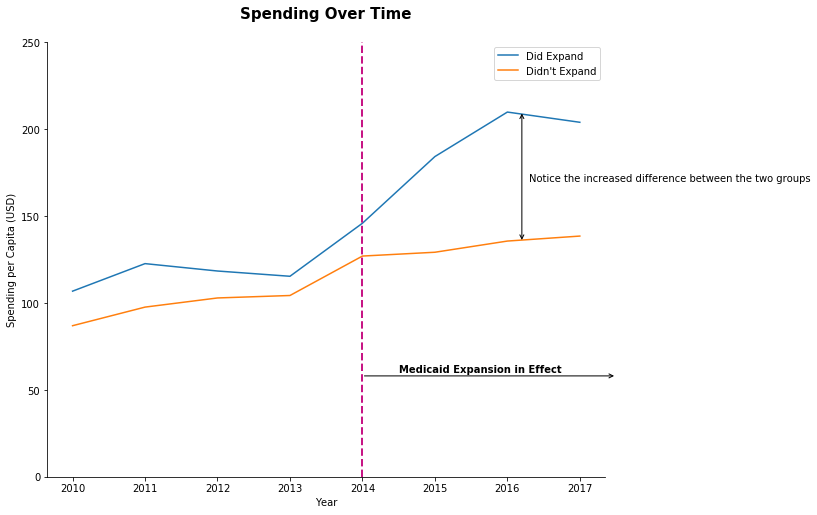

In [88]:
fig, ax = plt.subplots(figsize=(10,8))

yes_per_capita.plot(ax=ax, label = "Did Expand") # Label will be used for the legend

no_per_capita.plot(ax=ax, label = "Didn't Expand") # Label will be used for the legend

# Making clearer x labels and setting them:
xlabel_list = ["0","2010", "2011", "2012", "2013",
              "2014", "2015", "2016", "2017"] 
ax.set_xticklabels(xlabel_list)

ax.set_title("Spending Over Time\n", # Set the title
             fontsize=15,            # Change the font size
             fontweight="bold")      # Make it bold
ax.set_ylabel("Spending per Capita (USD)") # Set the y label
ax.set_xlabel("Year") # Set the x label

ax.set_ylim(0, 250) # Set the limits of the y axis

# Remove upper and right boundaries of graph:
ax.spines["right"].set_visible(False) 
ax.spines["top"].set_visible(False)

# To mark the year Medicaid expansion went into effect:
ax.axvline(x=4,             # Set the value to correspond to 2014
           color='#C71585', # make the color violet red
           linestyle='--',  # the line style
           linewidth=2)     # thickness of the line

# I then create a label for the line
message = "Medicaid Expansion in Effect"

ax.text(4.5, 60,  # Location of text
        message,  # Text is above message
        horizontalalignment='left', # Its alignment on the chart
        fontweight="bold")   # The text will be bold

ax.annotate("",   # There is no message for the arrow
            xy=(4, 58),  # The line starts here
            xytext=(7.5, 58), # And ends here
            arrowprops=dict(arrowstyle="<-")) # Type of arrow

# Legend:
handles, labels = ax.get_legend_handles_labels() # Retrieve the above labels for the legend

ax.legend(handles, labels) # Set the legend

# I want to point out the increasing difference between the two lines:
ax.annotate("Notice the increased difference between the two groups", # The message
    xy = (6.3, 170),   # Where message begins
    xytext=(6.3, 170), # This is about where the text is
    horizontalalignment="left", # How the text is aligned
    fontsize=10)                 # Set font size

ax.annotate("",           # No message
            xy=(6.2, 210), # Top limit of arrow
            xytext=(6.2, 135), # Bottom limit of arrow
            arrowprops=dict(arrowstyle="<->")) # Arrow type

plt.show()

The group-level analysis paints a much clearer picture of the general trend. It seems that the states the eventually decided to expand Medicaid have always spent more than the states that decide not to expand. Both lines generally follow the same pattern with a slight dip in spending from 2012 to 2013, followed by and increase in spending. However, after 2014, the spending for states that did not expand remains relatively flat, whereas there is a jump in spending for those that did expand Medicaid.

The increasing difference between the two lines really stands out to me, so I want to plot this difference over time. First, I will make a new dataframe with the difference:

In [89]:
difference = yes_per_capita - no_per_capita

In [90]:
difference

2010    19.863819
2011    24.997964
2012    15.489014
2013    11.051504
2014    18.871662
2015    55.001057
2016    74.159054
2017    65.412169
dtype: float64

Now I will plot this over time:

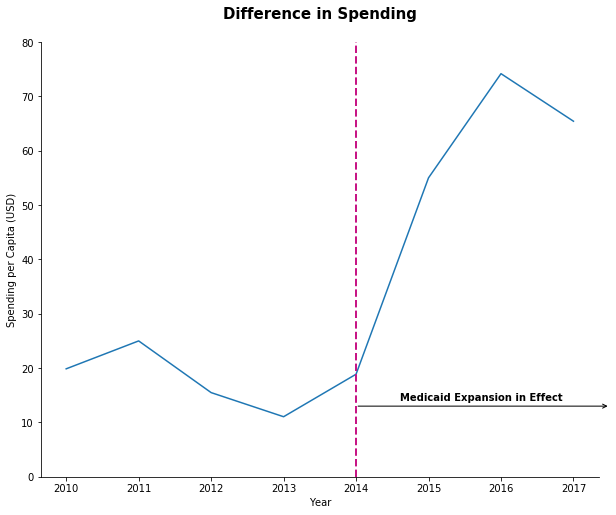

In [99]:
fig, ax = plt.subplots(figsize=(10,8))

difference.plot(ax=ax) # Plotting the difference over the years

# Making clearer x labels and setting them:
xlabel_list = ["0","2010", "2011", "2012", "2013",
              "2014", "2015", "2016", "2017"] 
ax.set_xticklabels(xlabel_list)


ax.set_title("Difference in Spending\n", # Set the title
             fontsize=15,                # Set the font size
             fontweight="bold")          # Set text to bold
ax.set_ylabel("Spending per Capita (USD)") # Set the y label
ax.set_xlabel("Year") # Set the x label

ax.set_ylim(0, 80) # Set the limits of the y axis

# Remove upper and right boundaries of graph:
ax.spines["right"].set_visible(False) 
ax.spines["top"].set_visible(False)

# To mark the year Medicaid expansion went into effect:
ax.axvline(x=4,           # Set the value to correspond to 2014
           color='#C71585', # make the color violet red
           linestyle='--',   # the line style
           linewidth=2)     # thickness of the line

# I then create a label for the line
message = "Medicaid Expansion in Effect"

# Same formatting for text placement, just with different coordinates:
ax.text(4.6, 14, message, horizontalalignment='left', fontweight="bold") # Message's position

# Same line formatting, just with different placement
ax.annotate("", xy=(4, 13), xytext=(7.5, 13),
        arrowprops=dict(arrowstyle="<-"))

plt.show()

The difference in spending begins increasing sharply after 2014. This corresponds with the Medicaid expansion date. Therefore, it appears that states that expanded Medicaid in 2014 began spending more than their non-expansion counterparts at the group level.

## Summary

This project set out to answer the following question: Did a state's decision to expand Medicaid have an effect on how much it spent on drug utilization? 

The key findings include:
* That spending has increased for both groups and at the national level
* The large jump in spending by Medicaid expansion states
    * The difference in spending between the two groups has increased greatly since 2014
* However, no clear trends exist at the individual state-level
    * Many factors are at play, so it is difficult to attribute large changes to just one
    * More research would need to be done on specific policies and budget allocations of individual states
    
Therefore, I would answer the above question with a yes. As a group, states that decided to expand Medicaid coverage in 2014 have increased their spending on drug utilization at a much faster rate than their non-expansion counterparts. This makes sense as Medicaid expansion involves covering a larger group of people as eligibility requirements are extended to people making a yearly income under 138% of the federal poverty line. The greater the number of people covered, the more medications should be covered by Medicaid. However, the expansion states have always spent at least a bit more on prescription reimbursements. These states could have been somehow predisposed to agree to Medicaid expansion. In the future, further research on why states decide to expand Medicaid would be interesting. Perhaps there are some key features that help predict whether or not a state decides to expand.